TAREA: Los ejemplos ilustrativos anteriores permiten saber el número de monedas presentes en la imagen. ¿Cómo saber la cantidad de dinero presente en ella? Sugerimos identificar de forma interactiva (por ejemplo haciendo clic en la imagen) una moneda de un valor determinado en la imagen (por ejemplo de 1€). Tras obtener esa información y las dimensiones en milímetros de las distintas monedas, realiza una propuesta para estimar la cantidad de dinero en la imagen. Muestra la cuenta de monedas y dinero sobre la imagen. No hay restricciones sobre utilizar medidas geométricas o de color.

Una vez resuelto el reto con la imagen ideal proporcionada, captura una o varias imágenes con monedas. Aplica el mismo esquema, tras identificar la moneda del valor determinado, calcula el dinero presente en la imagen. ¿Funciona correctamente? ¿Se observan problemas?

Nota: Para establecer la correspondencia entre píxeles y milímetros, comentar que la moneda de un euro tiene un diámetro de 23.25 mm. la de 50 céntimos de 24.35, la de 20 céntimos de 22.25, etc.

Extras: Considerar que la imagen pueda contener objetos que no son monedas y/o haya solape entre las monedas. Demo en vivo.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


7
0.7
[1.5857142857142859, 1.4285714285714286, 1.4857142857142858, 1.3714285714285714, 1.2142857142857144, 1.3, 1.1571428571428573, 1.0]
[131.61985778808594, 181.11985778808594, 152.4220733642578, 196.4479217529297, 159.89950561523438, 188.35629272460938, 171.74655151367188, 210.53005981445312]
2c
50c
5c
1e
20c
2e
10c
1c


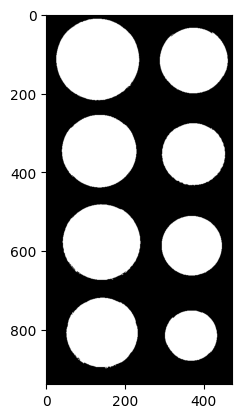

In [35]:
import cv2  
import numpy as np
import matplotlib.pyplot as plt
import csv

img = cv2.imread('Monedas.jpg') 
img_gris = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
th2,img_th2 = cv2.threshold(img_gris,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

contornos, hierarchy = cv2.findContours(img_th2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
cv2.drawContours(img_rgb, contornos, -1, (0,255,0), 3)
img_cont = np.zeros(img_rgb.shape)



proporciones = [1.11, 1, 1.04, 0.96, 0.85, 0.91, 0.81, 0.7]
tipo_de_moneda = ["2e", "1e", "50c", "20c", "10c", "5c", "2c", "1c"]

def lista_proporcional(tipo):
    pos = tipo_de_moneda.index(tipo)
    print(pos)
    valor = proporciones[pos]
    print(valor)
    tamaño_proporcional = []
    for i in proporciones:
        tamaño_proporcional.append(i/valor)
    return tamaño_proporcional

proporciones = lista_proporcional("1c")
print(proporciones)

def hallar_valor(diametro_seleccionado, diametro_nuevo, proporciones):
    proporcion_calculada = diametro_nuevo/diametro_seleccionado
    valor_mas_cercano = 1
    pos = 0
    contador = -1
    for i in proporciones:
        if (abs(proporcion_calculada - i) < valor_mas_cercano):
            valor_mas_cercano = abs(proporcion_calculada - i)
            pos = contador
        contador +=1

    return tipo_de_moneda[pos]

diametros_usar = []
donde = 0
for cnt in contornos:
    area = cv2.contourArea(cnt)
    if area > 10000:
        #print(donde)
        #print(area)
        perimetro = cv2.arcLength(cnt,True)

        #Contenedor alineado con ejes de la imagen
        x,y,w,h = cv2.boundingRect(cnt)
        #Mínimo contenedor ajustado para el contorno
        rect = cv2.minAreaRect(cnt)
        #Mínimo círculo que contiene al contorno
        (cx,cy),radio = cv2.minEnclosingCircle(cnt)
        diametros_usar.append(radio*2)
        #Elipse ajustada al contorno, exgigiendo un mínimo de puntos del contornos
        if cnt.shape[0] > 5:
            elipse = cv2.fitEllipse(cnt)
        cv2.drawContours(img_cont, [cnt], -1, (255,255,255), -1)
    donde+=1
plt.imshow(img_cont)
moneda = min(diametros_usar)
print(diametros_usar)
for i in diametros_usar:
    print(hallar_valor(moneda, i, proporciones))





            


TAREA: La tarea consiste en extraer características (geométricas y/o visuales) de las tres imágenes completas de partida, y aprender patrones que permitan identificar las partículas en nuevas imágenes. Para ello se proporciona como imagen de test MPs_test.jpg y sus correpondientes anotaciones MPs_test_bbs.csv con la que deben obtener las métricas para su propuesta de clasificación de microplásticos, además de la matriz de confusión. La matriz de confusión permitirá mostrar para cada clase el número de muestras que se clasifican correctamente de dicha clase, y el número de muestras que se clasifican incorrectamente como perteneciente a una de las otras dos clases